# Turing Target Practice

## Model

In [22]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [23]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot

using Revise
using MicroCanonicalHMC

In [24]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [25]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [72]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.25)#~ Normal(0.3, 0.1)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [73]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [74]:
target = TuringTarget(stat_model);

In [39]:
spl = MCHMC(0.0, 0.0, varE_wanted=2.0) #sqrt(target.d)*0.01

MicroCanonicalHMC.Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836), MicroCanonicalHMC.Leapfrog)

In [40]:
samples_mchmc = Sample(spl, target, 10000;
                       monitor_energy=true, 
                       dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 3417.8197174178663
eps: 0.25 --> VarE: 260.81240658340005
eps: 0.125 --> VarE: 16.947170906618748
eps: 0.0625 --> VarE: 4.967865175508085
eps: 0.03125 --> VarE: 0.25663024891428193
samples: 100--> ESS: 0.026443112250548052
samples: 243--> ESS: 0.00482707529914586
samples: 447--> ESS: 0.00435678210568962
samples: 739--> ESS: 0.008077680568855519


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳


samples: 1157--> ESS: 0.007125842741817308
samples: 1755--> ESS: 0.007087462944446244


[ Info: Found L: 1.4142135623730951 ✅


10001-element Vector{Any}:
 [0.5257980801790757, 0.7604401235641819, 0.0, 10.46990186147694]
 [0.5257980801790757, 0.7604401235641819, -0.43378359976687086, 9.861420985946795]
 [0.5272472375218131, 0.7814637538179748, -0.9874497911719651, 10.04757265863434]
 [0.5291037586473628, 0.7733762997539357, 0.605858851098489, 10.468845270304804]
 [0.5298268387095586, 0.7444952659000731, 0.42604699496645715, 10.09726915919679]
 [0.5304155685033936, 0.7148196251295138, -0.9030765021891494, 9.789555968776623]
 [0.5321947750156858, 0.706161951965979, -0.18251698098729108, 10.254208889765104]
 [0.5335033583068803, 0.7278372235884437, 0.6997636150839686, 10.200311689998864]
 [0.5340755491001088, 0.7574571340405996, -0.7138403073294679, 9.462034837227407]
 [0.5351055877608927, 0.7829188685768409, -1.2852437586559304, 9.65028461101158]
 [0.5368024619674957, 0.7756318090465782, 0.6775326611048218, 10.17426922453847]
 [0.5375546319133508, 0.7475419074028808, 0.7427495082594326, 9.948552069775264]
 [0.538

In [41]:
#plt.plot(samples_mchmc.E[8000:end])

In [42]:
#mean(samples_mchmc.E[8000:end])

In [43]:
#std(samples_mchmc.E[8000:end])^2/target.d

In [44]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

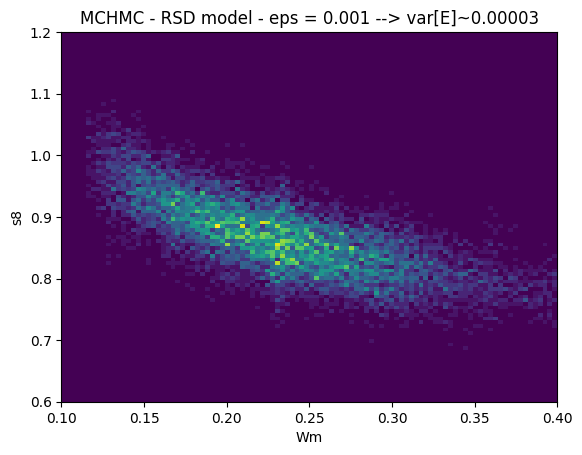

In [45]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

## AbstractMCMC

In [46]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: 2148.6598493321535
eps: 0.25 --> VarE: 102.86620545452067
eps: 0.125 --> VarE: 26.237719793950948
eps: 0.0625 --> VarE: 2.767032500479355
eps: 0.03125 --> VarE: 0.8362951119968115
samples: 100--> ESS: 0.017376712082733642
samples: 243--> ESS: 0.03304631498367915
samples: 447--> ESS: 0.02999783596075388


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 1.4142135623730951 ✅
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.66 seconds
Compute duration  = 1.66 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2271    0.0621     0.0006    0.0054    74.6769    1.0535     ⋯
          σ8    0.8725    0.0610     0.0006    0.0041   135.6515    1.0369     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1317    0.1814    0.2174    0.2648    0.3590
          σ8    0.7594    0.8301    0.8702    0.9130    0.9959


In [47]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.15 seconds
Compute duration  = 1.15 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2381    0.0653     0.0007    0.0057    86.6784    1.0015     ⋯
          σ8    0.8648    0.0606     0.0006    0.0040   175.7068    0.9999     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1396    0.1897    0.2304    0.2771    0.3896
          σ8    0.7548    0.8217    0.8621    0.9047    0.9899


In [48]:
#StatsPlots.plot(new_samples)

## NUTS

In [18]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 9.63 seconds
Compute duration  = 9.63 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2527    0.0603     0.0006    0.0013   2562.7177    1.0006    ⋯
          σ8    0.8532    0.0572     0.0006    0.0013   2006.9796    1.0005    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [19]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 501:1:10500
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.285347  0.760141  16.9836  7.0  1.0  …  3.0  0.0  0.623579  0.623579
 0.282042  0.87874   17.7146  3.0  1.0     2.0  0.0  0.623579  0.623579
 0.260376  0.852164  18.8225  3.0  1.0     1.0  0.0  0.623579  0.623579
 0.258577  0.810677  18.5194  7.0  1.0     2.0  0.0  0.623579  0.623579
 0.187008  0.884169  18.3451  7.0  1.0     3.0  0.0  0.623579  0.623579
 0.280042  0.833248  18.7198  7.0  1.0  …  2.0  0.0  0.623579  0.623579
 0.24345   0.895155  18.2319  7.0  1.0     3.0  0.0  0.623579  0.623579
 0.218612  0.834573  18.3982  7.0  1.0     3.0  0.0  0.623579  0.623579
 0.374874  0.790116  16.9625  7.0  1.0     2.0  0.0  0.623579  

In [20]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

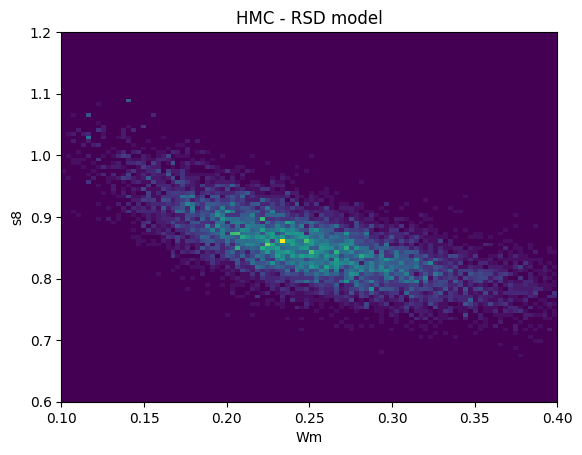

In [21]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");